First 5 rows of the dataset:
   Unnamed: 0           created_at  default_profile  default_profile_image  \
0           0  2016-10-15 21:32:11            False                  False   
1           1  2016-11-09 05:01:30            False                  False   
2           2  2017-06-17 05:34:27            False                  False   
3           3  2016-07-21 13:32:25             True                  False   
4           4  2012-01-15 16:32:35            False                  False   

                                         description  favourites_count  \
0  Blame @xaiax, Inspired by @MakingInvisible, us...                 4   
1  Photographing the American West since 1980. I ...               536   
2  Scruffy looking nerf herder and @twitch broadc...              3307   
3  Wife.Godmother.Friend.Feline Fanatic! Assistan...              8433   
4               Loan coach at @mancity & Aspiring DJ                88   

   followers_count  friends_count  geo_enabled           

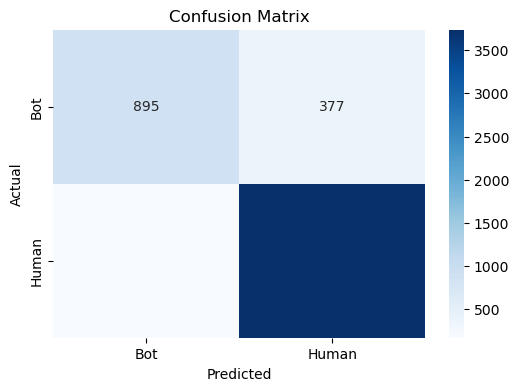


Feature Importances:
                   Feature  Importance
3          followers_count    0.231240
2         favourites_count    0.171095
4            friends_count    0.161935
6           statuses_count    0.121807
8   average_tweets_per_day    0.119483
9         account_age_days    0.091660
7                 verified    0.035220
10            lang_encoded    0.032818
5              geo_enabled    0.021648
0          default_profile    0.012639
1    default_profile_image    0.000454


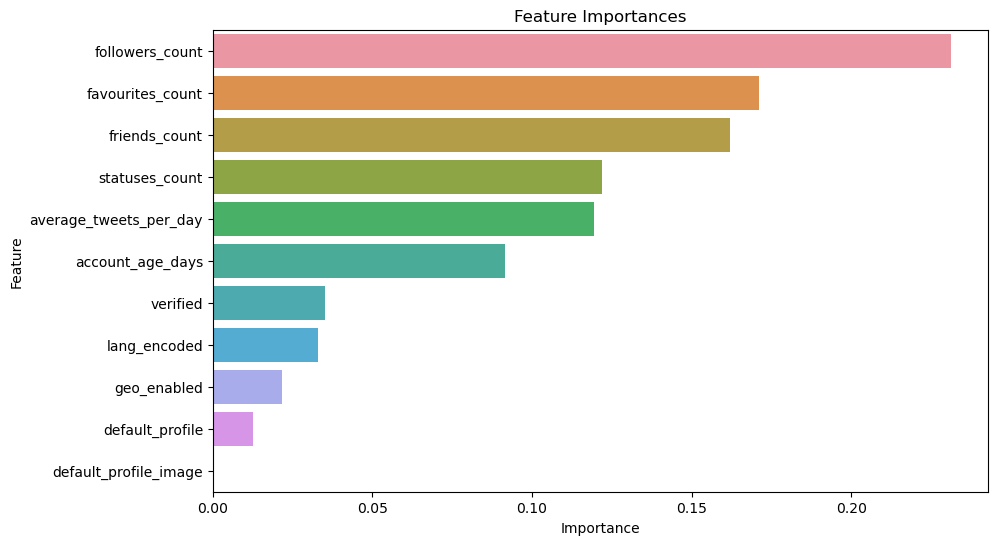

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Download the dataset CSV file from the Hugging Face repository
url = "https://huggingface.co/datasets/airt-ml/twitter-human-bots/resolve/main/twitter_human_bots_dataset.csv"
response = requests.get(url)
with open("twitter_human_bots_dataset.csv", "wb") as f:
    f.write(response.content)

# Read the CSV file using pandas
df = pd.read_csv("twitter_human_bots_dataset.csv")

# Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Handle missing values by dropping rows with any missing values
df = df.dropna().reset_index(drop=True)

# Encode 'account_type' (our target variable)
le = LabelEncoder()
df['account_type_encoded'] = le.fit_transform(df['account_type'])  # 'bot' -> 0, 'human' -> 1

# Convert Boolean columns to integers
boolean_cols = ['default_profile', 'default_profile_image', 'geo_enabled', 'verified']
for col in boolean_cols:
    df[col] = df[col].astype(int)

# Encode 'lang' column (if needed)
df['lang_encoded'] = le.fit_transform(df['lang'])

# Select relevant features for modeling
df_model = df.drop(columns=[
    'Unnamed: 0', 'created_at', 'description', 'id',
    'profile_background_image_url', 'profile_image_url',
    'screen_name', 'location', 'account_type', 'lang'
])

# Features (X) and target variable (y)
X = df_model.drop('account_type_encoded', axis=1)
y = df_model['account_type_encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Initialize and train the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set and evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy on the test set: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Bot', 'Human']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Bot', 'Human'], yticklabels=['Bot', 'Human']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importance
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names, 'Importance': importances
}).sort_values('Importance', ascending=False)
print("\nFeature Importances:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()
